# Используемые ресурсы

In [537]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import openpyxl
from sklearn.tree import plot_tree

import seaborn as sns
import matplotlib.pyplot as plt

# Сбор и препроцессинг данных

In [352]:
# Загрузка данных (необходимо адаптировать пути к файлам)
data = pd.read_excel('Porivi_in_2_cities-main/Poriv.xlsx', engine='openpyxl')
data2 = pd.read_excel('Porivi_in_2_cities-main/Poriv2.xlsx', engine='openpyxl')

In [1002]:
common_columns = list(set(data.columns) & set(data2.columns))

for column in common_columns:
    data[column] = data[column].astype(str)
    data2[column] = data2[column].astype(str)
    
merged_data_by_common_columns = pd.merge(data, data2, how='outer', on=common_columns)

In [1003]:
selected_columns = [
    "Утончение стенки, %",
    "Наличие других порывов на участке, К2",
    "Коррозионная активность грунта, К3",
    "Наличие/отсутствие затопления (следов затопления) канала, К4",
    "Наличие пересечений с коммуникациями, К5",
    "Ki (действ)"
]

df_common = merged_data_by_common_columns[selected_columns].copy()

df_common = df_common.rename(columns={'Утончение стенки, %': 'Утончение стенки K1, %', 
                                      'Наличие других порывов на участке, К2': 'Порывы, K2', 
                                      'Коррозионная активность грунта, К3': 'Корр. грунта, K3', 
                                      'Наличие/отсутствие затопления (следов затопления) канала, К4': 'Затопление, K4',
                                      'Наличие пересечений с коммуникациями, К5': 'Коммуникации, K5',
                                      'Ki (действ)': 'Ki'})
df_common

,"Утончение стенки K1, %","Порывы, K2","Корр. грунта, K3","Затопление, K4","Коммуникации, K5",Ki
0,34.2857142857143,нет,низкая,нет,нет,1.19833819463617
1,17.5,нет,низкая,да,нет,1.03903553773497
2,20.0,да,средняя,да,да,1.11736007329225
3,52.5,нет,низкая,нет,нет,1.2910500634762
4,17.5,да,средняя,да,да,1.24478341974083
...,...,...,...,...,...,...
107,64.2857142857143,да,низкая,да,нет,0.983204860033999
108,44.4444444444444,да,высокая,да,да,0.887564876999618
109,30.0,да,низкая,нет,нет,1.42308010998884
110,50.0,да,высокая,нет,нет,1.15897209358047


In [1004]:
# Превращаем колонки в числовой тип
df_common['Утончение стенки K1, %'] = pd.to_numeric(df_common['Утончение стенки K1, %'], errors='coerce')
df = df_common.dropna(subset=['Утончение стенки K1, %'], inplace=True)
df_common['Ki'] = pd.to_numeric(df_common['Ki'], errors='coerce')

# Кодируем строковые признаки
df_common['Порывы, K2'] = df_common['Порывы, K2'].astype('category')
df_common['Порывы, K2'] = df_common['Порывы, K2'].cat.codes
df_common['Корр. грунта, K3'] = df_common['Корр. грунта, K3'].astype('category')
df_common['Корр. грунта, K3'] = df_common['Корр. грунта, K3'].cat.codes
df_common['Затопление, K4'] = df_common['Затопление, K4'].astype('category')
df_common['Затопление, K4'] = df_common['Затопление, K4'].cat.codes
df_common['Коммуникации, K5'] = df_common['Коммуникации, K5'].astype('category')
df_common['Коммуникации, K5'] = df_common['Коммуникации, K5'].cat.codes

In [1005]:
for column in df_common.columns:
        df_common[column] = pd.to_numeric(df_common[column], errors='ignore')
        
for column in df_common.columns:
    if df_common[column].dtype in ['int64', 'float64'] and df_common[column].isnull().any():
        mean_value = df_common[column].mean()
        df_common.loc[:, column] = df_common[column].fillna(mean_value)
    elif df_common[column].dtype == 'object' and df_common[column].isnull().any():
        mode_value = df_common[column].mode()[0]
        df_common.loc[:, column] = df_common[column].fillna(mode_value)

for column in df_common.columns:
    if df_common[column].dtype == 'object':
        df_common.loc[:, column] = df_common[column].astype('category')
        
print(df_common.info())
df_common

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 0 to 111
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Утончение стенки K1, %  111 non-null    float64
 1   Порывы, K2              111 non-null    int8   
 2   Корр. грунта, K3        111 non-null    int8   
 3   Затопление, K4          111 non-null    int8   
 4   Коммуникации, K5        111 non-null    int8   
 5   Ki                      111 non-null    float64
dtypes: float64(2), int8(4)
memory usage: 3.0 KB
None


,"Утончение стенки K1, %","Порывы, K2","Корр. грунта, K3","Затопление, K4","Коммуникации, K5",Ki
0,34.285714,1,1,1,1,1.198338
1,17.500000,1,1,0,1,1.039036
2,20.000000,0,2,0,0,1.117360
3,52.500000,1,1,1,1,1.291050
4,17.500000,0,2,0,0,1.244783
...,...,...,...,...,...,...
107,64.285714,0,1,0,1,0.983205
108,44.444444,0,0,0,0,0.887565
109,30.000000,0,1,1,1,1.423080
110,50.000000,0,0,1,1,1.158972


# Разведывательный анализ

In [357]:
df_common_corr = df_common.copy()
df_common_corr = df_common_corr.rename(columns={'Утончение стенки K1, %' : 'K1', 
                                                'Порывы, K2' : 'K2', 
                                                'Корр. грунта, K3' : 'K3', 
                                                'Затопление, K4' : 'K4',
                                                'Коммуникации, K5' : 'K5'})

In [358]:
corr_matrix = df_common_corr.corr()

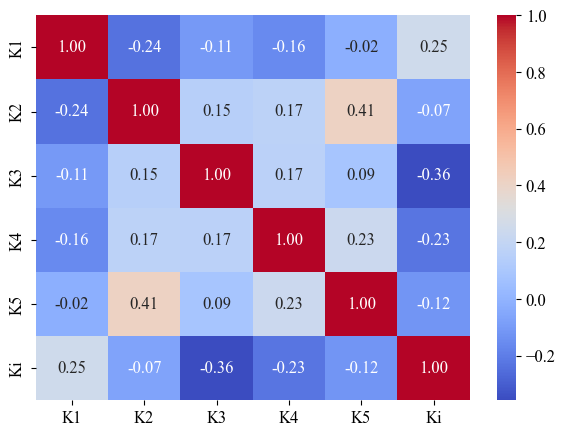

In [359]:
plt.figure(figsize=(7, 5))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
#plt.title('Матрица корреляции')
plt.savefig('corr_matrix.png', dpi = 300, transparent = True)
plt.show()

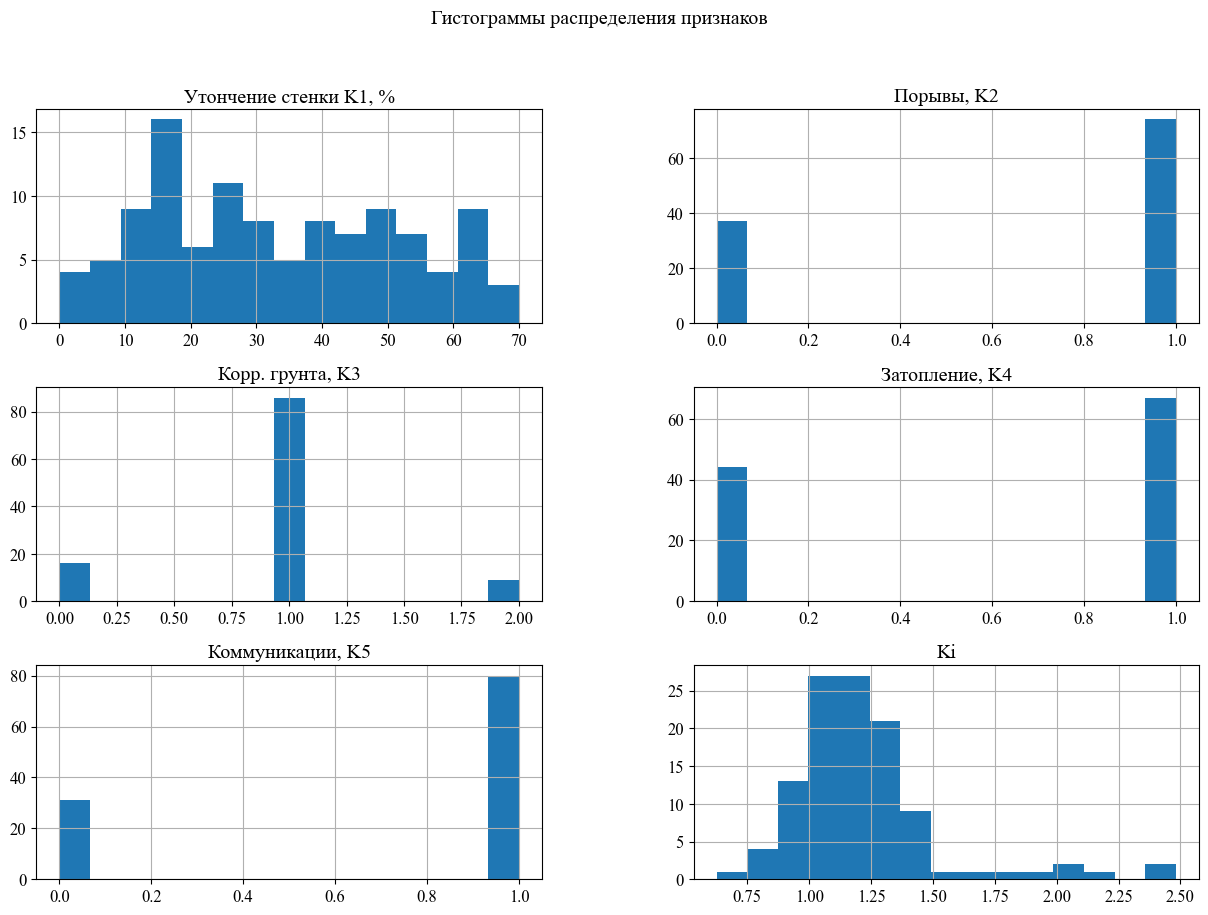

In [360]:
# Гистограммы для непрерывных признаков
df_common.hist(bins=15, figsize=(15, 10))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.suptitle('Гистограммы распределения признаков')
plt.savefig('histogram.png', dpi = 300, transparent = True)
plt.show()

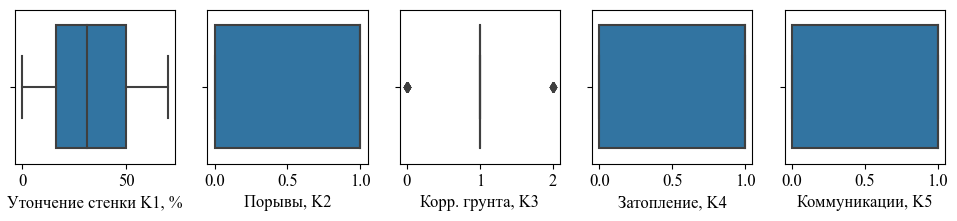

In [361]:
# Ящики с усами для категориальных признаков
plt.figure(figsize=(12, 2))
for index, feature in enumerate(["Утончение стенки K1, %", 
                                 "Порывы, K2", 
                                 "Корр. грунта, K3", 
                                 "Затопление, K4", 
                                 "Коммуникации, K5"]):
    plt.subplot(1, 5, index + 1)
    sns.boxplot(x=df_common[feature])

plt.tight_layout
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.savefig('box.png', dpi = 300, transparent = True)
plt.show()

In [362]:
# разделение генеральной совокупности на обучающую тестовую и валидационную выборки
X = df_common.drop('Ki', axis=1)
y = df_common['Ki']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [363]:
# Дополнительное разделение обучающего набора на обучающий и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

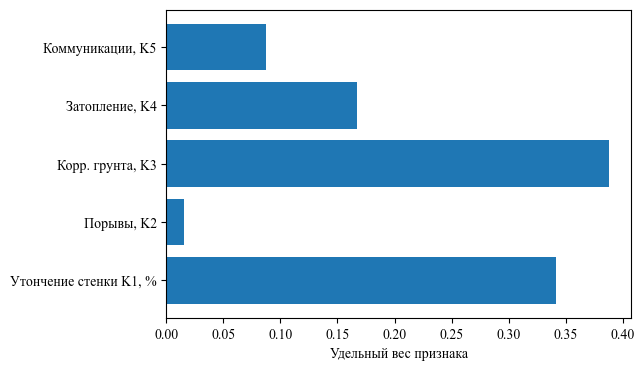

In [1009]:
# Оценка ценности признаков
selector = GradientBoostingRegressor(random_state=42)
selector.fit(X_train, y_train)

# Вывод важности признаков
feature_importances = selector.feature_importances_
features = X_train.columns

plt.figure(figsize=(6, 4))
plt.barh(range(len(features)), feature_importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Удельный вес признака')
plt.savefig('feature_important.png', dpi = 300, transparent = True)
#plt.title('Feature Importance')
plt.show()

# Обучение моделей

In [496]:
X = df_common.drop('Ki', axis=1)
y = df_common['Ki']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df_common)
# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [497]:
# Дополнительное разделение обучающего набора на обучающий и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)  # 0.25 x 0.8 = 0.2

## Tensorflow

In [498]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_dim=5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mape', 'mse', 'r2_score'])

history = model.fit(X_train, y_train, epochs=50, batch_size=11, validation_data=(X_val, y_val), verbose = 0)
#model.predict(X_train)

C:\Users\Nadezhda\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [499]:
# Получение истории потерь и MAE
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1, len(loss) + 1)

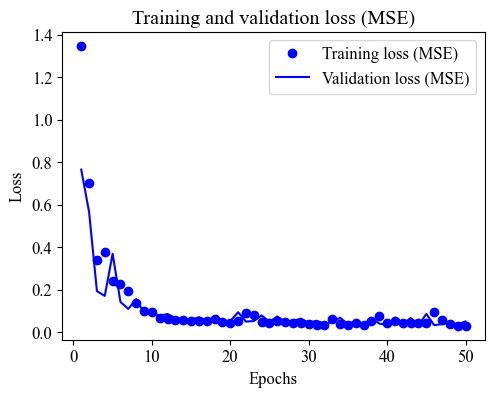

In [500]:
# График потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss (MSE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MSE)')
plt.title('Training and validation loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.savefig('loss_MSE.png', dpi = 300, transparent = True)
plt.show()

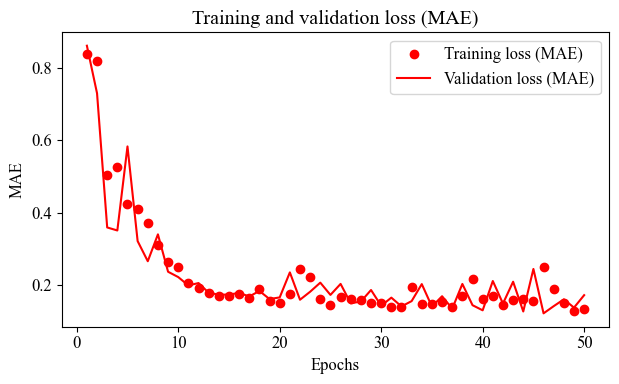

In [501]:
# График MAE
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'ro', label='Training loss (MAE)')
plt.plot(epochs, val_mae, 'r', label='Validation loss (MAE)')
plt.title('Training and validation loss (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.savefig('loss_MAE.png', dpi = 300, transparent = True)
plt.show()

In [726]:
# Оценка производительности модели на тестовых данных
test_loss, test_mae, test_mape, test_mse, test_R2 = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}, MAE: {test_mae}, MAPE: {test_mape/100}, MSE: {test_mse}, R2: {1/-test_R2}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0275 - mae: 0.1197 - mape: 10.7171 - mse: 0.0275 - r2_score: -2.9265
Test Loss: 0.027496328577399254, MAE: 0.11971205472946167, MAPE: 0.107171049118042, MSE: 0.027496328577399254, R2: 0.34170206456511504


In [747]:
predictions = {}
errors = pd.DataFrame()
MSE, MAE, MAPE = {}, {}, {}

In [748]:
# погрешность в тестовой выборке
y_pred = model.predict(X_test)
y_pred = np.asarray(list(i[0] for i in y_pred))
predictions['MLP'] = y_pred
errors['MLP'] = (y_pred - y_val)/y_val
MSE['MLP'], MAE['MLP'], MAPE['MLP'] = test_mse, test_mae, test_mape/100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


## Support Vector Machine

In [577]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Регуляризационный параметр
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Параметр ядра
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1],  # Параметр маржи
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Тип ядра
}

svr = SVR()


grid_search = GridSearchCV(estimator=svr, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=-1)

In [95]:
# Обучение модели
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 400 candidates, totalling 800 fits


GridSearchCV(cv=2, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [692]:
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


In [751]:
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test)
predictions['SVM'] = y_pred
errors['SVM'] = (y_pred - y_val)/y_val

In [753]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = -r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.008578039765169677
Mean Absolute Error: 0.08223057431835015
Mean Absolute Percentage Error: 0.07329555042932075
R^2 Score: 0.22494084940784465


In [754]:
MSE['SVM'], MAE['SVM'], MAPE['SVM'] = mse, mae, mape

## Ensemble Methods

### Gradient Boosting

In [600]:
# Пайплайн для Gradient Boosting
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor())
])

# Параметры для GridSearchCV Gradient Boosting
gb_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Создание и выполнение GridSearchCV для Gradient Boosting
gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=5, scoring='neg_mean_absolute_percentage_error')
gb_grid.fit(X_train, y_train)

print("Лучшие GBRT-параметры:", gb_grid.best_params_)

Лучшие GBRT-параметры: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 7, 'regressor__n_estimators': 100}


In [755]:
best_gb = gb_grid.best_estimator_
y_pred = best_gb.predict(X_test)
predictions['GBRT'] = y_pred
errors['GBRT'] = (y_pred - y_val)/y_val

In [756]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = -r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.00869450185938922
Mean Absolute Error: 0.07710398759244601
Mean Absolute Percentage Error: 0.06834791621578631
R^2 Score: 0.2415715926222044


In [757]:
MSE['GBRT'], MAE['GBRT'], MAPE['GBRT'] = mse, mae, mape

### Random Forest

In [616]:
# Пайплайн для Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Параметры для GridSearchCV Random Forest
rf_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_features': [0.3, 'sqrt', 'log2'],
    'regressor__max_depth': [5, 10, 15]
}

# Создание и выполнение GridSearchCV для Random Forest
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_absolute_percentage_error')
rf_grid.fit(X_train, y_train)

print("Лучшие RF-параметры:", rf_grid.best_params_)

Лучшие RF-параметры: {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 100}


In [758]:
best_rf = rf_grid.best_estimator_
best_r_rf = rf_grid.best_estimator_.named_steps['regressor']
y_pred = best_rf.predict(X_test)
predictions['RF'] = y_pred
errors['RF'] = (y_pred - y_val)/y_val

In [759]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = -r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.007570978518476511
Mean Absolute Error: 0.07846340054075297
Mean Absolute Percentage Error: 0.06976779097051303
R^2 Score: 0.08113288247128092


In [760]:
MSE['RF'], MAE['RF'], MAPE['RF'] = mse, mae, mape

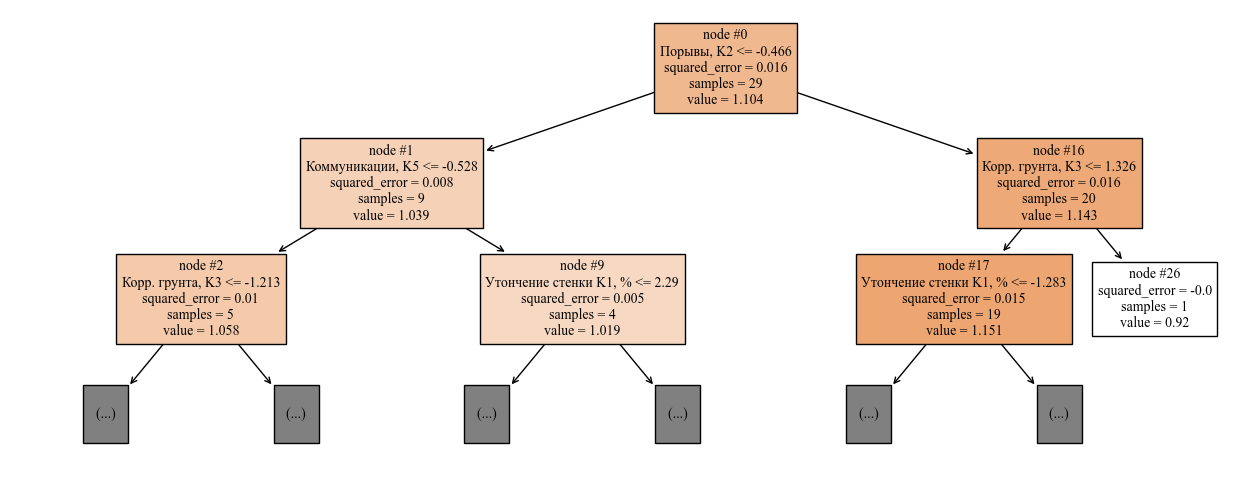

In [918]:
# Отрисовка первого дерева из лучшей модели
fig, ax = plt.subplots(figsize=(16, 6))
plot_tree(best_r_rf.estimators_[0], 
          filled=True, 
          feature_names=df_common.columns.tolist(), 
          ax=ax, 
          fontsize=10, 
          max_depth=2, 
          node_ids=True)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.savefig('tree.png', dpi = 300, transparent = True)

plt.show()

# Сравнение метрик моделей

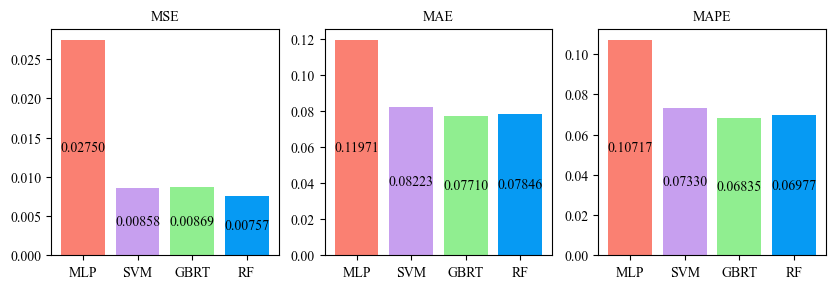

In [994]:
models = list(MSE)
plt.figure(figsize=(10, 10))

for index, score in enumerate(['MSE', 'MAE', 'MAPE']):
    scores = [MSE, MAE, MAPE]
    
    plt.subplot(3, 3, index + 1)
    bars =plt.bar(models, 
            scores[index].values(), 
            color=['#FA8072', '#C79FEF', '#90EE90', '#069AF3'],
            align='center')
    
    plt.bar_label(bars, label_type='center', fmt='%.5f')
    plt.title(score, fontsize = 10)
    
plt.tight_layout
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.savefig('scores.png', dpi = 300, transparent = True)
plt.show()

In [858]:
errors.reset_index(drop=True, inplace=True)
errors.reset_index(drop=False, inplace=True)
errors.head()

,index,MLP,SVM,GBRT,RF
0,0,-0.212530,-0.145597,-0.158453,-0.144941
1,1,-0.135091,-0.196277,-0.202064,-0.155043
2,2,-0.262152,0.052505,-0.033729,0.007160
3,3,0.253816,0.029460,0.107313,0.035614
4,4,-0.355397,-0.079550,-0.025321,-0.048912


In [903]:
df_errors1 = errors[['index', 'MLP']]
df_errors1.insert(loc=2,column='score', value='MLP')
df_errors1 = df_errors1.rename(columns={'MLP':'error'})

df_errors2 = errors[['index', 'SVM']]
df_errors2.insert(loc=2,column='score', value='SVM')
df_errors2 = df_errors2.rename(columns={'SVM':'error'})

df_errors3 = errors[['index', 'GBRT']]
df_errors3.insert(loc=2,column='score', value='GBRT')
df_errors3 = df_errors3.rename(columns={'GBRT':'error'})

df_errors4 = errors[['index', 'RF']]
df_errors4.insert(loc=2,column='score', value='RF')
df_errors4 = df_errors4.rename(columns={'RF':'error'})

df_errors = pd.concat([df_errors1, df_errors2, df_errors3, df_errors4], axis=0)
df_errors = df_errors.rename(columns={'index':'Номер инцидента', 
                                      'error':'Относительная ошибка',
                                      'score': 'Модель'})
df_errors.head(4)

,Номер инцидента,Относительная ошибка,Модель
0,0,-0.212530,MLP
1,1,-0.135091,MLP
2,2,-0.262152,MLP
3,3,0.253816,MLP


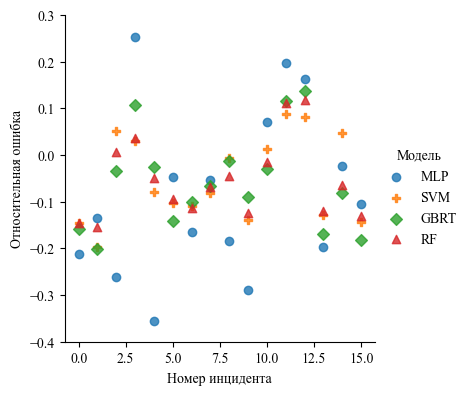

In [1021]:
# Относительная ошибка на валидационных данных
sns.lmplot(x='Номер инцидента', 
           y='Относительная ошибка', 
           data=df_errors,
           fit_reg=False, 
           hue='Модель', 
           legend=True,
           markers=["o", "P", "D", "^"],
           scatter=True, 
           height=4)

#plt.legend(loc='best')
plt.ylim(-0.4, 0.3)
plt.savefig('relative_error', dpi = 300, transparent = True)

plt.show()

MLP показал наибольший разброс относительной ошибки, из-за чего модель была исключена из дальнейшего анализа

# Фильтрация и переоценка моделей

Удаляем самый слабый признак – порывы, К2 (обоснование – п. 3. Разведывательный анализ). Исключаем самый слабый метод – MLP

In [922]:
X_train2 = X_train.drop(['Порывы, K2'], axis=1)
X_test2 = X_test.drop(['Порывы, K2'], axis=1)

In [923]:
MSE2, MAE2, MAPE2 = {}, {}, {}

## Support Vector Machine

In [938]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Регуляризационный параметр
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Параметр ядра
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1],  # Параметр маржи
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Тип ядра
}

svr = SVR()

grid_search = GridSearchCV(estimator=svr, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=-1)

In [939]:
%%time

# Обучение модели
grid_search.fit(X_train2, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
CPU times: total: 750 ms
Wall time: 18 s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

In [940]:
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


In [941]:
best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test2)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = -r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.008630453524431092
Mean Absolute Error: 0.07966109212106187
Mean Absolute Percentage Error: 0.07021225973219791
R^2 Score: 0.2324255145000993


In [937]:
MSE2['SVM'], MAE2['SVM'], MAPE2['SVM'] = mse, mae, mape

## Gradient Boosting

In [969]:
X = df_common.drop('Ki', axis=1)
y = df_common['Ki']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df_common)
# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [970]:
# Дополнительное разделение обучающего набора на обучающий и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [971]:
X_train = X_train.drop(['Порывы, K2'], axis=1)
X_test = X_test.drop(['Порывы, K2'], axis=1)

In [978]:
# Пайплайн для Gradient Boosting
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor())
])

# Параметры для GridSearchCV Gradient Boosting
gb_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Создание и выполнение GridSearchCV для Gradient Boosting
gb_grid = GridSearchCV(gb_pipeline, gb_params, cv=5, scoring='neg_mean_absolute_percentage_error')
gb_grid.fit(X_train, y_train)

print("Лучшие GBRT-параметры:", gb_grid.best_params_)

Лучшие GBRT-параметры: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}


In [979]:
best_gb = gb_grid.best_estimator_
y_pred = best_gb.predict(X_test)

In [980]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = -r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.0066423294828226506
Mean Absolute Error: 0.06720413278777157
Mean Absolute Percentage Error: 0.06051006046276036
R^2 Score: -0.4528000247006454


In [981]:
MSE2['GBRT'], MAE2['GBRT'], MAPE2['GBRT'] = mse, mae, mape

## Random Forest

In [972]:
# Пайплайн для Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Параметры для GridSearchCV Random Forest
rf_params = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_features': [0.3, 'sqrt', 'log2'],
    'regressor__max_depth': [5, 10, 15]
}

# Создание и выполнение GridSearchCV для Random Forest
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_absolute_percentage_error')
rf_grid.fit(X_train, y_train)

print("Лучшие RF-параметры:", rf_grid.best_params_)

Лучшие RF-параметры: {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 100}


In [973]:
best_rf = rf_grid.best_estimator_
best_r_rf = rf_grid.best_estimator_.named_steps['regressor']
y_pred = best_rf.predict(X_test)

In [974]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = -r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.0071037312281429735
Mean Absolute Error: 0.06851629041976263
Mean Absolute Percentage Error: 0.06280568747849036
R^2 Score: -0.41478941045826523


In [975]:
MSE2['RF'], MAE2['RF'], MAPE2['RF'] = mse, mae, mape

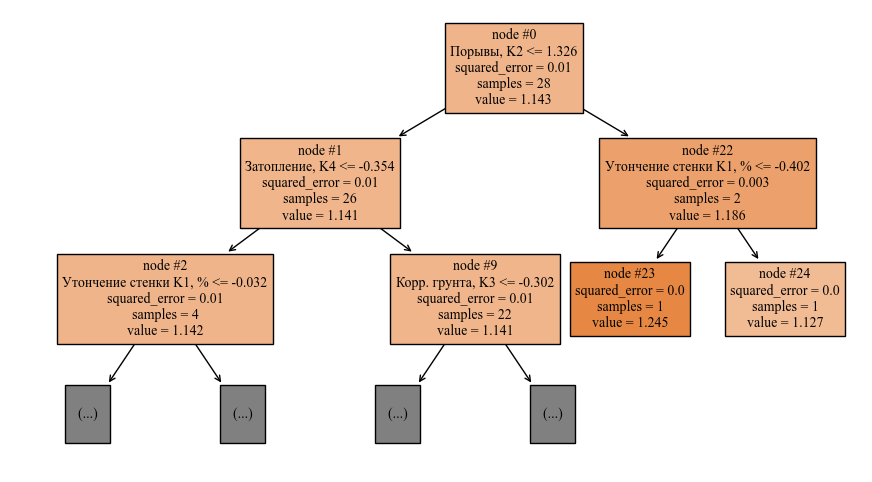

In [990]:
# Отрисовка первого дерева из лучшей модели
fig, ax = plt.subplots(figsize=(11, 6))
plot_tree(best_r_rf.estimators_[0], 
          filled=True, 
          feature_names=df_common.columns.tolist(), 
          ax=ax, 
          fontsize=10, 
          max_depth=2, 
          node_ids=True)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.savefig('tree2.png', dpi = 300, transparent = True)

plt.show()

## Сравнение метрик моделей

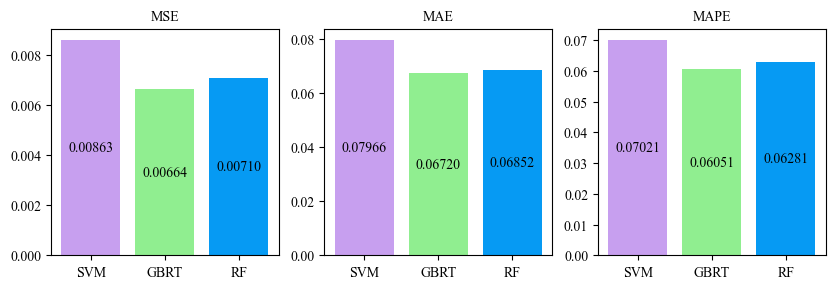

In [982]:
models = list(MSE2)
plt.figure(figsize=(10, 10))

for index, score in enumerate(['MSE', 'MAE', 'MAPE']):
    scores = [MSE2, MAE2, MAPE2]
    
    plt.subplot(3, 3, index + 1)
    bars =plt.bar(models, 
            scores[index].values(), 
            color=['#C79FEF', '#90EE90', '#069AF3'],
            align='center')
    
    plt.bar_label(bars, label_type='center', fmt='%.5f')
    plt.title(score, fontsize = 10)
    
plt.tight_layout
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.savefig('scores2.png', dpi = 300, transparent = True)
plt.show()

**Вывод**: Лучший результат получен для GBRT-модели